[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/capExtra/capX-crossentropy.ipynb) 

# Método Cross-Entropy


## 1 - Configurações Iniciais

### Cria Diretório para Experimentos

In [1]:
!mkdir results

J� existe uma subpasta ou um arquivo results.


### Configurações Dependentes do Sistema

Rode a célula abaixo, mesmo sem estar no Colab.

In [2]:
import sys
from IPython.display import clear_output

if 'google.colab' in sys.modules:
    !pip install swig
    !pip install gymnasium[box2d]
    !pip install optuna


    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )


### Imports Principais

Import algoritmos, ambientes e outros módulos.

In [4]:
import gym
import numpy as np
import optuna

from util.experiments import repeated_exec
from util.plot import plot_result, plot_multiple_results
from util.notebook import display_videos_from_path

#from montecarlo_v2 import run_montecarlo2
#from qlearning import run_qlearning
#from expected_sarsa import run_expected_sarsa
from models_torch import test_policy
from crossentropy_method_v1 import run_crossentropy_method1, PolicyModelCrossentropy

## 2 - Rodando o Método Cross-Entropy (v1)

In [10]:
#ENV_NAME, rmax = "CartPole-v1", 500
#ENV_NAME, rmax = "Acrobot-v1", 0
ENV_NAME, rmax = "LunarLander-v2", 300
#ENV_NAME, rmax = "MountainCar-v0", 0  # resultados ruins

env = gym.make(ENV_NAME)

EPISODES   = 800    # total de episódios
BATCH_SIZE = 10      # quantidade de episódios executados por época de treinamento
PROPORTION = 0.2    # percentual dos episódios (do batch) que serão selecionados

policy_model = PolicyModelCrossentropy(env.observation_space.shape[0], [512], env.action_space.n, lr=0.005)
returns, policy1 = run_crossentropy_method1(env, EPISODES, BATCH_SIZE, PROPORTION)
clear_output()

print("Últimos episódios do treinamento: media =", np.mean(returns[-20:]), ", desvio padrao =", np.std(returns[-20:]))


Últimos episódios do treinamento: media = -56.11929321744604 , desvio padrao = 55.38574072709304


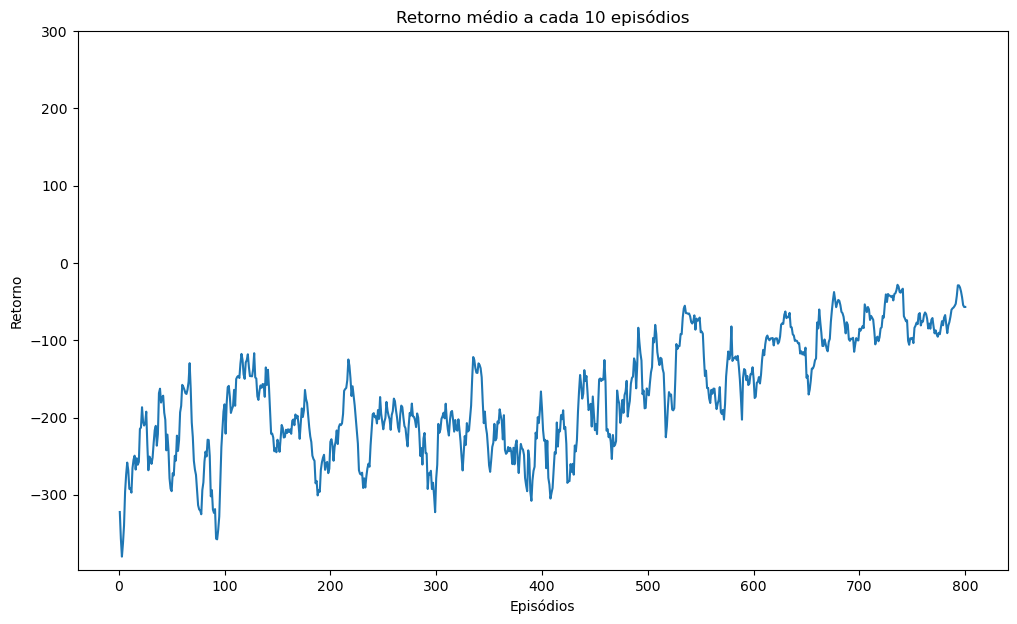

In [11]:
# Exibe um gráfico episódios x retornos (não descontados)
plot_result(returns, rmax)

In [ ]:
# Roda alguns episódigos com o modelo e salva os vídeos em arquivos
env1 = gym.make(ENV_NAME, render_mode="rgb_array")
video_env=gym.wrappers.RecordVideo(env1, "./videos", episode_trigger=(lambda ep : True), video_length=3_000)
test_policy(video_env, policy1, False, 3)
video_env.close()

In [13]:
display_videos_from_path('./videos')

## 3 - Experimentos


### 3.1 Parâmetros do Cross-Entropy

Abaixo, mostramos experimentos variando os dois parâmetros mais diretos do método:
- o tamanho de batch (de episódios)
- a proporção dos episódios selecionados

***Atenção***: de forma geral, os resultados variam muito, porque dependem da inicialização da rede neural, que é aleatória. Para resultados mais confiáveis, use um número mais alto de repetições do que estamos usando abaixo. Tente com algumas *dezenas*.

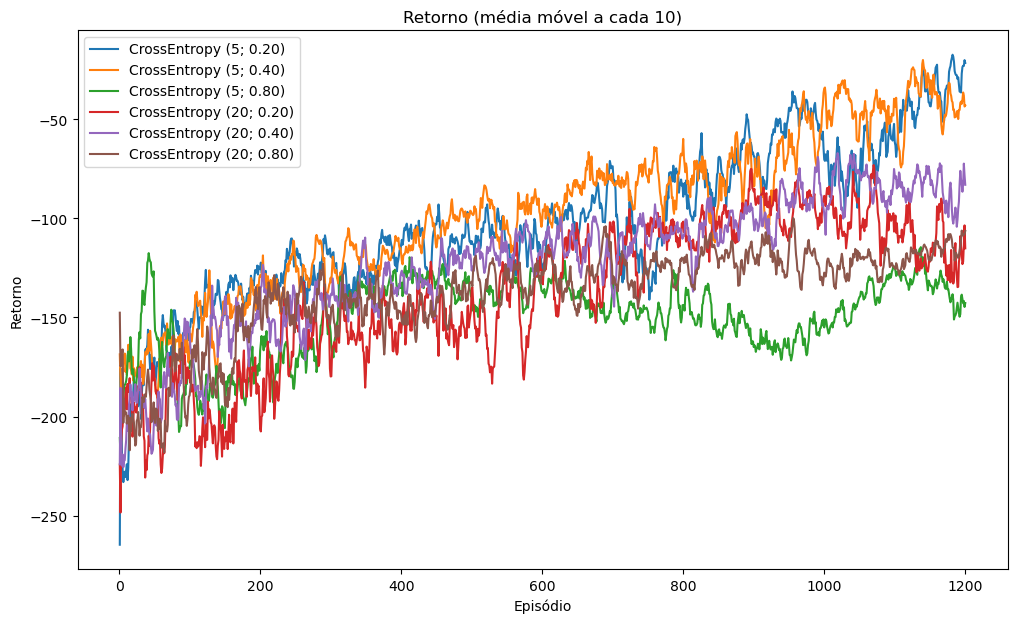

In [15]:
env = gym.make(ENV_NAME)
NUM_EPISODES = 1_200
RUNS = 5

results1 = []

for batch_size in [5, 20]:
    #results = []
    for proportion in [1/5.0, 2/5.0, 4/5.0]:
        results1.append( repeated_exec(RUNS, f"CrossEntropy ({batch_size}; {proportion:.2f})", run_crossentropy_method1, env, NUM_EPISODES, batch_size, proportion) )
        clear_output()
    #plot_multiple_results(results1, cumulative=False, x_log_scale=False)

plot_multiple_results(results1, cumulative=False, x_log_scale=False)


### 3.2 Parâmetros da Rede Neural (da Política)

Você também pode variar todos os parâmetros da rede neural: quantidade de camadas, taxa de aprendizagem, etc.

In [16]:
env = gym.make(ENV_NAME)

NUM_EPISODES = 1_200
BATCH_SIZE   = 20
PROPORTION   = 0.4

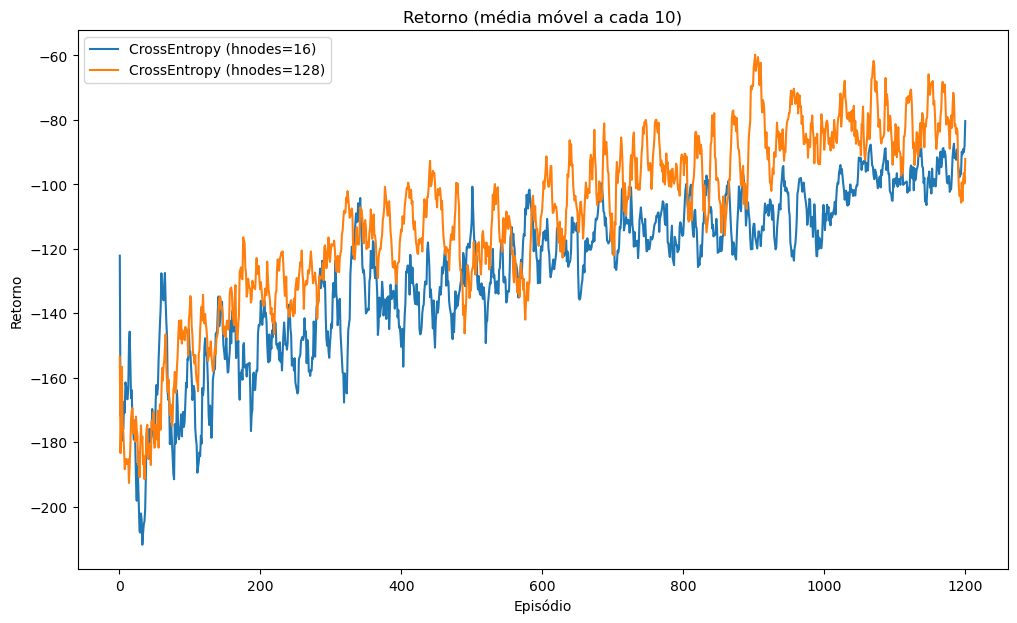

In [17]:
results2 = []

for hidden_layer_size in [16, 128]:
    policy_model = PolicyModelCrossentropy(env.observation_space.shape[0], [hidden_layer_size], env.action_space.n, lr=0.01)
    results2.append( repeated_exec(RUNS, f"CrossEntropy (hnodes={hidden_layer_size})", run_crossentropy_method1, env, NUM_EPISODES, BATCH_SIZE, PROPORTION, policy_model) )
    clear_output()

plot_multiple_results(results2, cumulative=False, x_log_scale=False)

## 4 - Comparação com o Crossentropy v2

O v2 é uma versão melhorada, onde um batch dos episódios *elite* (os melhores de toda a execução) são mantidos.

In [18]:
from crossentropy_method_v2 import run_crossentropy_method2

In [19]:
#ENV_NAME, rmax = "CartPole-v1", 500
#ENV_NAME, rmax = "Acrobot-v1", 0
ENV_NAME, rmax = "LunarLander-v2", 300
#ENV_NAME, rmax = "MountainCar-v0", 0  # resultados ruins

RUNS = 5

In [20]:
env = gym.make(ENV_NAME)
policy = PolicyModelCrossentropy(env.observation_space.shape[0], [256,256], env.action_space.n)

results3 = []

results3.append( repeated_exec(RUNS, f"CrossEntropy-2 (20; 0.1)", run_crossentropy_method2, env, NUM_EPISODES, 20, 0.1, policy) )
results3.append( repeated_exec(RUNS, f"CrossEntropy-1 (20; 0.1)", run_crossentropy_method1, env, NUM_EPISODES, 20, 0.1, policy) )

Executing <function run_crossentropy_method2 at 0x000001DAFCB4ADD0>:


100%|██████████| 5/5 [05:00<00:00, 60.06s/it]


  (5 executions of CrossEntropy-2 (20; 0.1) finished in 300.32 secs)
Executing <function run_crossentropy_method1 at 0x000001DAEBF99900>:


100%|██████████| 5/5 [07:37<00:00, 91.49s/it]

  (5 executions of CrossEntropy-1 (20; 0.1) finished in 457.44 secs)


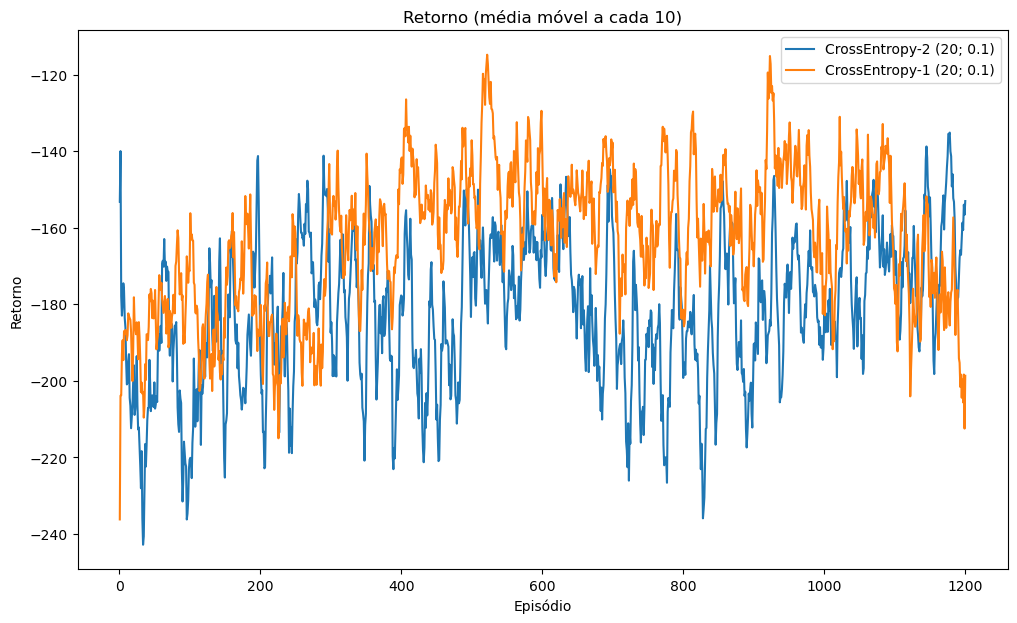

In [23]:
#plot_multiple_results(results3, cumulative=False, x_log_scale=False, yreference=rmax)
plot_multiple_results(results3, cumulative=False, x_log_scale=False)

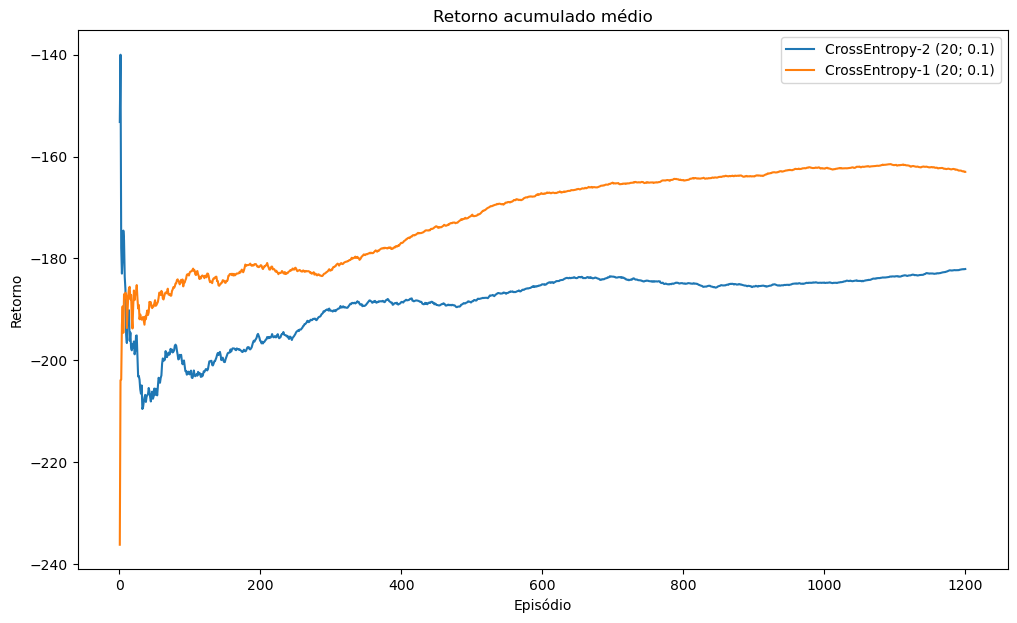

In [24]:

plot_multiple_results(results3, cumulative=True, x_log_scale=False)